In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, accuracy_score
import plotting
import joblib

from sklearn.datasets import fetch_openml
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, Y = data['data'].to_numpy(), data['target'].to_numpy()

In [2]:
print(data['feature_names'])
print(X.shape, Y.shape)
print(Y[:12])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
['g' 'w' 't' 'z' 'w' 'w' 't' 'g' 'z' 'g' 't' 'q']


In [3]:
LE = LabelEncoder()
Y = LE.fit_transform(Y)
Y[:12]

array([0, 3, 2, 4, 3, 3, 2, 0, 4, 0, 2, 1])

In [4]:
Y = to_categorical(Y, 5)
Y[:12]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [5]:
train_ratio = 0.6
val_ratio = 0.392
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
scaler = StandardScaler().fit(X_train_val)
del X_train_val
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))


Partition the data set into train/val/test: 0.60/0.39/0.01
X_train.shape: (497999, 16)
Y_train.shape: (497999, 5)
X_val.shape: (325360, 16)
Y_val.shape: (325360, 5)
X_test.shape: (6641, 16)
Y_test.shape: (6641, 5)


In [ ]:
model = tf.keras.Sequential()
model.add(layers.InputLayer(input_shape = (16,), name = 'input'))
model.add(layers.Dense(64, name = 'fc1'))
model.add(layers.Activation('relu', name = 'relu1'))
model.add(layers.Dense(32, name = 'fc2'))
model.add(layers.Activation('relu', name = 'relu2'))
model.add(layers.Dense(32, name = 'fc3'))
model.add(layers.Activation('relu', name = 'relu3'))
model.add(layers.Dense(5 , name = 'output'))
model.add(layers.Activation('softmax', name = 'softmax'))
model.summary()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [ ]:
history = model.fit(X_train, Y_train,
                    epochs = 20,
                    validation_data = (X_val, Y_val),
                    batch_size = 1024,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, mode = "min")
                    ])

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
model.save('model')

In [ ]:
model = tf.keras.models.load_model('model')
model.summary()

In [ ]:
Y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

In [ ]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.001, 1)
    plt.grid(True)
    plt.legend(loc='best')  
    
plt.figure(figsize=(6, 6))
plot_roc(Y_test, Y_pred, LE.classes_)

In [ ]:
LE.classes_

In [ ]:
Y_pred.shape

In [ ]:
@@@

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=6)
pca.fit(X_test)
X_test = pca.transform(X_test)
X_test.shape

In [6]:
from pysr import PySRRegressor

model_pysr = PySRRegressor(
    model_selection="best",  # Result is mix of simplicity+accuracy
    niterations=10,
    select_k_features=6,
    binary_operators=["+", "*"],
    unary_operators=[
        #"cos",
        "exp",
        #"sin",
        "inv(x) = 1/x",
	# ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(x, y) = (x - y)^2"
    # ^ Custom loss function (julia syntax)
)

In [7]:
model_pysr.fit(X_test, Y_test)

/Users/ho-fung/miniforge3/envs/symbolic/lib/python3.9/site-packages/pysr/sr.py:1225: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Using features ['x2' 'x3' 'x4' 'x11' 'x14' 'x15']


  Activating project at `~/.julia/environments/pysr-0.10.1`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.10.1/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.10.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.10.1/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.10.1/Manifest.toml`
  No Changes to `~/.julia/environments/pysr-0.10.1/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.10.1/Manifest.toml`


Started!

Cycles per second: 2.900e+04
Head worker occupation: 13.1%
Progress: 81 / 750 total iterations (10.800%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           1.612e-01  1.109e-06  0.20193484
5           1.306e-01  5.255e-02  ((x15 * 0.17435722) + 0.20313223)
7           1.120e-01  7.697e-02  (0.16970943 * (x15 + inv(exp(x3))))
9           1.105e-01  6.418e-03  (0.16970943 * ((x15 * 1.6449445) + inv(exp(x3))))
11          1.063e-01  1.945e-02  inv(exp(exp(x15 * -1.1686721) * (exp(x3) + 0.56414723)))
17          1.008e-01  8.825e-03  inv(exp((exp(x15 * -1.1686721) * (exp(x3) + 0.56414723)) + ((x2 + 0.2765489) * 0.46579015)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           1.559e-01  1.147e-06  0.19318771
5           1.216e-01  6.215e-02  (0.1472494 * inv(exp(x14)))
6           1.204e-01  9.600e-03  exp((x

PySRRegressor.equations_ = [
[
	   pick     score                                           equation  \
	0        0.000000                                         0.20193484   
	1        0.052551                   ((x15 + 1.1650747) * 0.17430303)   
	2        0.078377                (0.17949611 * (x15 + inv(exp(x3))))   
	3        0.026883  ((x15 + (inv(exp(x3)) + -0.54128903)) * 0.2457...   
	4  >>>>  0.125954  inv(exp(exp(((x15 * -1.2975248) + 0.814432) + ...   
	5        0.002885  inv(exp((((x15 * -2.152193) + (x3 * x11)) + 2....   
	6        0.001379  inv(exp((((x15 * -2.152193) + (x3 * x11)) + 2....   
	7        0.004201  inv(exp(exp(((x14 + x3) * (0.0891116 * x11)) +...   
	8        0.003455  inv(exp(exp(((x14 + x3) * (0.0891116 * (-0.384...   
	
	       loss  complexity  
	0  0.161152           1  
	1  0.130601           5  
	2  0.111652           7  
	3  0.105808           9  
	4  0.093286          10  
	5  0.091950          15  
	6  0.091697          17  
	7  0.091312         

In [8]:
print(model_pysr)

PySRRegressor.equations_ = [
[
	   pick     score                                           equation  \
	0        0.000000                                         0.20193484   
	1        0.052551                   ((x15 + 1.1650747) * 0.17430303)   
	2        0.078377                (0.17949611 * (x15 + inv(exp(x3))))   
	3        0.026883  ((x15 + (inv(exp(x3)) + -0.54128903)) * 0.2457...   
	4  >>>>  0.125954  inv(exp(exp(((x15 * -1.2975248) + 0.814432) + ...   
	5        0.002885  inv(exp((((x15 * -2.152193) + (x3 * x11)) + 2....   
	6        0.001379  inv(exp((((x15 * -2.152193) + (x3 * x11)) + 2....   
	7        0.004201  inv(exp(exp(((x14 + x3) * (0.0891116 * x11)) +...   
	8        0.003455  inv(exp(exp(((x14 + x3) * (0.0891116 * (-0.384...   
	
	       loss  complexity  
	0  0.161152           1  
	1  0.130601           5  
	2  0.111652           7  
	3  0.105808           9  
	4  0.093286          10  
	5  0.091950          15  
	6  0.091697          17  
	7  0.091312         

In [9]:
Y_pysr=model_pysr.predict(X_test)

In [10]:
model_pysr.equations_

[   complexity      loss     score  \
 0           1  0.161152  0.000000   
 1           5  0.130601  0.052551   
 2           7  0.111652  0.078377   
 3           9  0.105808  0.026883   
 4          10  0.093286  0.125954   
 5          15  0.091950  0.002885   
 6          17  0.091697  0.001379   
 7          18  0.091312  0.004201   
 8          20  0.090684  0.003455   
 
                                             equation  \
 0                                         0.20193484   
 1                   ((x15 + 1.1650747) * 0.17430303)   
 2                (0.17949611 * (x15 + inv(exp(x3))))   
 3  ((x15 + (inv(exp(x3)) + -0.54128903)) * 0.2457...   
 4  inv(exp(exp(((x15 * -1.2975248) + 0.814432) + ...   
 5  inv(exp((((x15 * -2.152193) + (x3 * x11)) + 2....   
 6  inv(exp((((x15 * -2.152193) + (x3 * x11)) + 2....   
 7  inv(exp(exp(((x14 + x3) * (0.0891116 * x11)) +...   
 8  inv(exp(exp(((x14 + x3) * (0.0891116 * (-0.384...   
 
                                         sympy

In [11]:
Y_pysr.shape

(6641, 5)

In [12]:
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pysr, axis=1))))

Accuracy: 0.6986899563318777


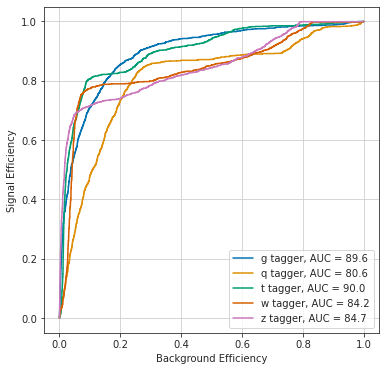

In [13]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.001, 1)
    plt.grid(True)
    plt.legend(loc='best')  
    
plt.figure(figsize=(6, 6))
plot_roc(Y_test, Y_pysr, LE.classes_)

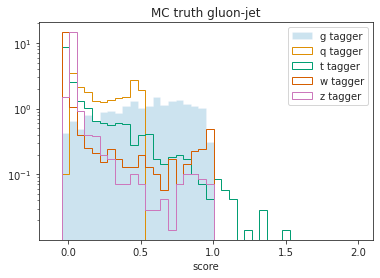

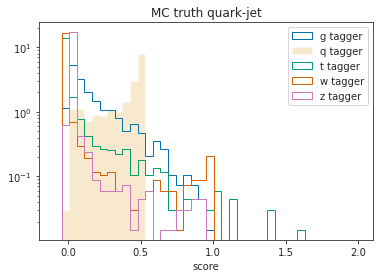

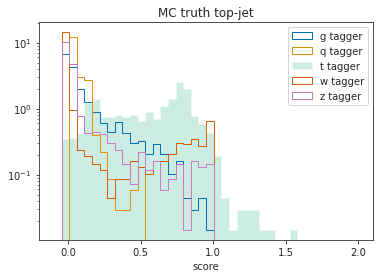

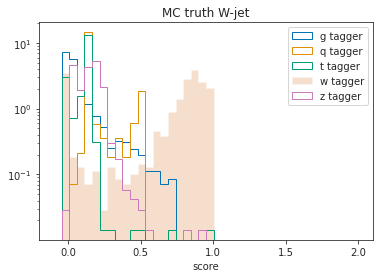

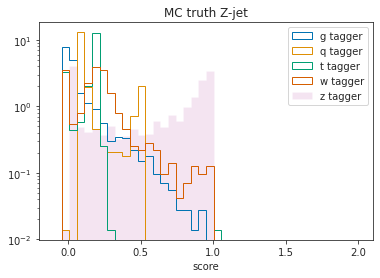

In [14]:
nbins=40
rmin=-0.1
rmax=2
plt.hist(Y_pysr[Y_test[:,0]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,0]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,0]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,0]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,0]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth gluon-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,1]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,1]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='q tagger')
plt.hist(Y_pysr[Y_test[:,1]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,1]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,1]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth quark-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,2]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,2]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,2]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='t tagger')
plt.hist(Y_pysr[Y_test[:,2]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,2]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth top-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,3]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,3]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,3]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,3]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='w tagger')
plt.hist(Y_pysr[Y_test[:,3]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth W-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,4]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,4]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,4]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,4]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,4]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='z tagger')
plt.legend(loc='best')
plt.title('MC truth Z-jet')
plt.xlabel('score')
plt.show()